In [1]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

In [4]:
import opendatasets as od
import os
import random
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

In [6]:
dataset_url = 'https://www.kaggle.com/datasets/andrewmvd/pediatric-pneumonia-chest-xray'
od.download(dataset_url)

# Assume `od.download(dataset_url)` is a function to download and extract the dataset

def load_images_from_directory(directory):
    images, labels = [], []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for file_name in os.listdir(label_path):
                if file_name.endswith(".jpeg"):
                    image_path = os.path.join(label_path, file_name)
                    image = cv2.imread(image_path)
                    if image is not None:
                        # Resize image and convert to array
                        image = cv2.resize(image, (32, 32))
                        image = img_to_array(image)
                        images.append(image)
                        labels.append(label)  # Use folder name as label
    # Convert lists to numpy arrays and normalize pixel values
    return np.array(images, dtype="float") / 255.0, np.array(labels)

# Define paths for train and test sets
train_path = '/content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train'
test_path = '/content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test'

# Load and preprocess the datasets
x_train, y_train = load_images_from_directory(train_path)
x_test, y_test = load_images_from_directory(test_path)

# Convert string labels to integer labels using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Converts 'NORMAL'/'PNEUMONIA' to integers
y_test = label_encoder.transform(y_test)

# Convert integer labels to one-hot encoding
num_classes = len(label_encoder.classes_)  # Calculate number of classes
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Check loaded data
print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')
print("Classes:", label_encoder.classes_)



Skipping, found downloaded files in "./pediatric-pneumonia-chest-xray" (use force=True to force download)
Training samples: 5232, Testing samples: 624
Classes: ['NORMAL' 'PNEUMONIA']


In [7]:
# Define the teacher model
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define the student model (fewer layers)
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (32, 32, 3)  # Updated input shape




In [8]:
teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile and train the teacher model
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Precompute teacher's predictions for distillation
teacher_preds = teacher.predict(x_train)

Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7142 - loss: 0.5944 - val_accuracy: 0.6250 - val_loss: 0.6066 - learning_rate: 0.0100
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8291 - loss: 0.3945 - val_accuracy: 0.8397 - val_loss: 0.3416 - learning_rate: 0.0100
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9451 - loss: 0.1597 - val_accuracy: 0.8157 - val_loss: 0.5133 - learning_rate: 0.0100
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9582 - loss: 0.1102 - val_accuracy: 0.8462 - val_loss: 0.3800 - learning_rate: 0.0100
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9723 - loss: 0.0786 - val_accuracy: 0.7692 - val_loss: 0.6409 - learning_rate: 0.0100
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9701 - loss: 0.0747 - val_accuracy: 0.7372 - val_loss: 0.9978 - learning_rate: 0.0100
Epoch 7/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9762 - loss: 0.0653 

In [9]:
def distillation_loss(y_true, y_pred, teacher_preds, student_model, temperature=3.0, alpha=0.1):
    # Get predictions from the teacher model and apply temperature scaling
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true = tf.keras.activations.softmax(y_true / temperature)
    y_pred = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)

    # Compute the soft loss and hard loss components
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Ensure the first layer has weights
    first_layer = student_model.layers[0]
    if hasattr(first_layer, 'weights') and len(first_layer.weights) > 0:
        # Extract weights from the first layer and compute nuclear norm
        first_layer_weights = first_layer.weights[0]  # Access weights directly
        singular_values = tf.linalg.svd(first_layer_weights, compute_uv=False)
        nuclear_norm = tf.reduce_sum(singular_values)
    else:
        # If no weights exist, set nuclear_norm to 0
        nuclear_norm = 0

    # Return the combined loss
    return alpha * soft_loss + (1. - alpha) * hard_loss + alpha * nuclear_norm

In [11]:
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

Teacher test accuracy: 76.76%


In [10]:
student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds, student_model=student),
    metrics=['accuracy']
)
student.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])


Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.7768 - loss: 0.6904 - val_accuracy: 0.7692 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9470 - loss: 0.6851 - val_accuracy: 0.7644 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9610 - loss: 0.6845 - val_accuracy: 0.7885 - val_loss: 0.6909 - learning_rate: 0.0010
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9751 - loss: 0.6842 - val_accuracy: 0.7147 - val_loss: 0.6942 - learning_rate: 0.0010
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9786 - loss: 0.6841 - val_accuracy: 0.8317 - val_loss: 0.6892 - learning_rate: 0.0010
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9843 - loss: 0.6839 - val_accuracy: 0.8045 - val_loss: 0.6896 - learning_rate: 0.0010
Epoch 7/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9882 - loss: 0.6837

In [12]:
#teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
#print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')

Student test accuracy: 79.49%


In [14]:
from sklearn.metrics import classification_report
import time

def evaluate_model(model, x_test, y_test):
    # Predict the labels
    start_time = time.time()
    y_pred_probs = model.predict(x_test)
    inference_time = time.time() - start_time

    # Get the predicted classes
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate precision, recall, F1 score
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)

    # Print the metrics
    print(report)
    print(f"Inference Time: {inference_time:.4f} seconds")
    return y_pred_probs

print("=== Teacher Model Evaluation ===")
teacher_pred_probs = evaluate_model(teacher, x_test, y_test)

print("\n=== Student Model Evaluation ===")
student_pred_probs = evaluate_model(student, x_test, y_test)

=== Teacher Model Evaluation ===
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

      NORMAL       1.00      0.38      0.55       234
   PNEUMONIA       0.73      1.00      0.84       390

    accuracy                           0.77       624
   macro avg       0.86      0.69      0.70       624
weighted avg       0.83      0.77      0.73       624

Inference Time: 0.1231 seconds

=== Student Model Evaluation ===
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

      NORMAL       0.96      0.47      0.63       234
   PNEUMONIA       0.76      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.86      0.73      0.74       624
weighted avg       0.83      0.79      0.77       624

Inference Time: 0.6060 seconds


In [16]:

alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5]
f1_scores = []
accuracies = []
precisions = []
recalls = []
inference_times = []

teacher_preds = teacher.predict(x_train)

# Function to evaluate F1-score, accuracy, precision, recall, and inference time for a given model and alpha
def evaluate_student_with_alpha(alpha):
    # Redefine distillation loss function with current alpha
    def distillation_loss(y_true, y_pred, teacher_preds, student_model, temperature=3.0, alpha=alpha):
        # Scale teacher predictions and student predictions by temperature
        teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
        y_true = tf.keras.activations.softmax(y_true / temperature)
        y_pred = tf.keras.activations.softmax(y_pred / temperature)
        teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)

        # Calculate soft loss and hard loss
        soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Ensure the first layer has weights
        first_layer = student_model.layers[0]
        if hasattr(first_layer, 'weights') and len(first_layer.weights) > 0:
            # Extract first layer's weights from the student model and compute nuclear norm
            first_layer_weights = first_layer.weights[0]  # Access weights directly
            singular_values = tf.linalg.svd(first_layer_weights, compute_uv=False)
            nuclear_norm = tf.reduce_sum(singular_values)
        else:
            # If no weights exist, set nuclear_norm to 0
            nuclear_norm = 0

        # Combine losses with nuclear norm regularization
        return alpha * (soft_loss + nuclear_norm) + (1. - alpha) * hard_loss

    # Compile the student model with the new distillation loss
    student.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds, student_model=student),
        metrics=['accuracy']
    )

    # Train the student model
    student.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test),
                callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

    # Predict and evaluate
    start_time = time.time()
    y_pred_probs = student.predict(x_test)
    inference_time = time.time() - start_time
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate and store F1-score, accuracy, precision, recall, and inference time
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Append the results
    f1_scores.append(f1)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    inference_times.append(inference_time)

    # Print classification report
    print(f"=== Classification Report for Alpha: {alpha} ===")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    print(f"Inference Time: {inference_time:.4f} seconds\n")
    print(f"Alpha: {alpha} - F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Run evaluation for each alpha
for alpha in alpha_values:
    evaluate_student_with_alpha(alpha)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
=== Classification Report for Alpha: 0.1 ===
              precision    recall  f1-score   support

      NORMAL       0.97      0.38      0.54       234
   PNEUMONIA       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.69       624
weighted avg       0.82      0.76      0.73       624

Inference Time: 0.6805 seconds

Alpha: 0.1 - F1 Score: 0.7272, Accuracy: 0.7612, Precision: 0.8164, Recall: 0.7612
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
=== Classification Report for Alpha: 0.2 ===
              precision    recall  f1-score   support

      NORMAL       0.97      0.39      0.56       234
   PNEUMONIA       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.85      0.69      0.70       624
weighted avg       0.82      0.77      0.74       624

Inference Time: 0.70

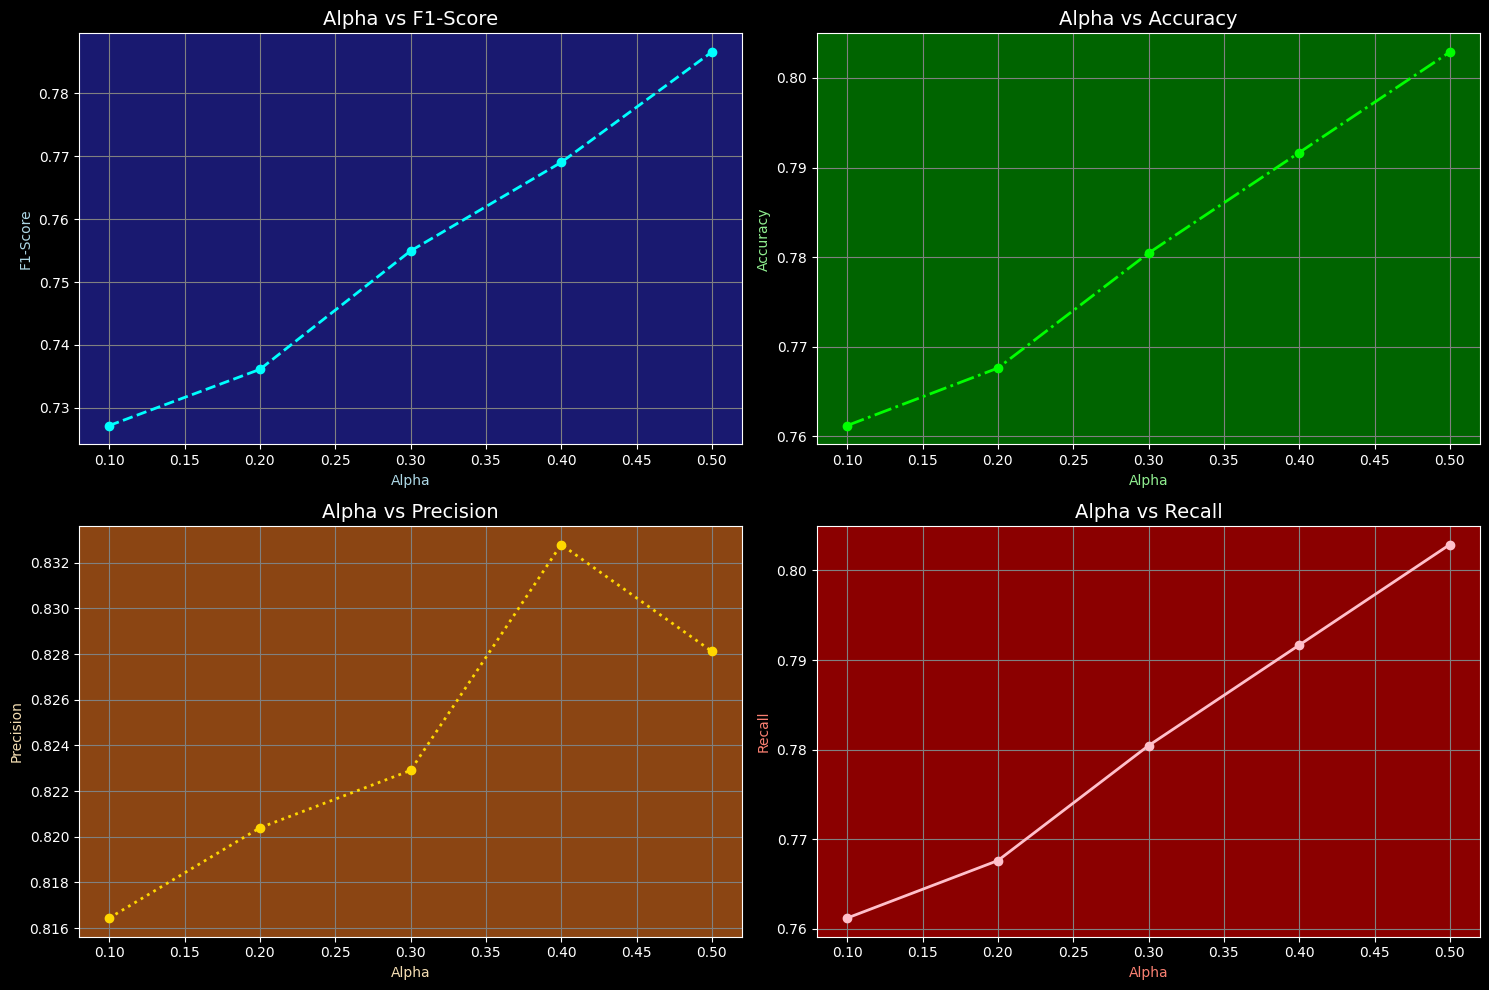

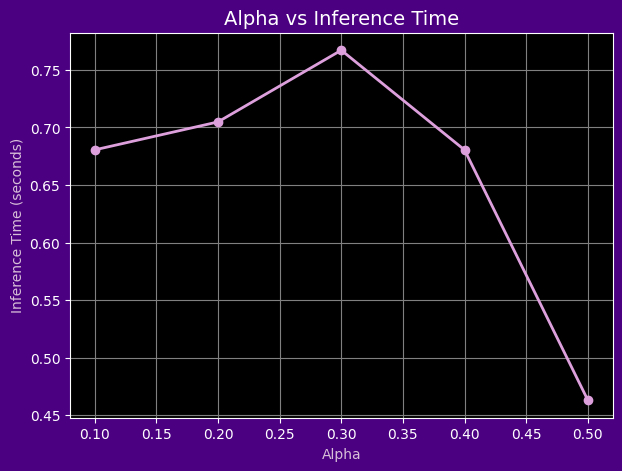

In [17]:
plt.style.use('dark_background')

plt.figure(figsize=(15, 10))

# Alpha vs F1-Score with a custom background color
plt.subplot(2, 2, 1, facecolor='midnightblue')
plt.plot(alpha_values, f1_scores, marker='o', color='cyan', linestyle='--', linewidth=2)
plt.title("Alpha vs F1-Score", fontsize=14, color='white')
plt.xlabel("Alpha", color='lightblue')
plt.ylabel("F1-Score", color='lightblue')
plt.grid(True, color='gray')

# Alpha vs Accuracy with a custom background color
plt.subplot(2, 2, 2, facecolor='darkgreen')
plt.plot(alpha_values, accuracies, marker='o', color='lime', linestyle='-.', linewidth=2)
plt.title("Alpha vs Accuracy", fontsize=14, color='white')
plt.xlabel("Alpha", color='lightgreen')
plt.ylabel("Accuracy", color='lightgreen')
plt.grid(True, color='gray')

# Alpha vs Precision with a custom background color
plt.subplot(2, 2, 3, facecolor='saddlebrown')
plt.plot(alpha_values, precisions, marker='o', color='gold', linestyle=':', linewidth=2)
plt.title("Alpha vs Precision", fontsize=14, color='white')
plt.xlabel("Alpha", color='wheat')
plt.ylabel("Precision", color='wheat')
plt.grid(True, color='gray')

# Alpha vs Recall with a custom background color
plt.subplot(2, 2, 4, facecolor='darkred')
plt.plot(alpha_values, recalls, marker='o', color='pink', linestyle='-', linewidth=2)
plt.title("Alpha vs Recall", fontsize=14, color='white')
plt.xlabel("Alpha", color='salmon')
plt.ylabel("Recall", color='salmon')
plt.grid(True, color='gray')

plt.tight_layout()
plt.show()

# Plot Inference Time vs. Alpha with custom background color separately
plt.figure(figsize=(7, 5), facecolor='indigo')
plt.plot(alpha_values, inference_times, marker='o', color='plum', linestyle='-', linewidth=2)
plt.title("Alpha vs Inference Time", fontsize=14, color='white')
plt.xlabel("Alpha", color='thistle')
plt.ylabel("Inference Time (seconds)", color='thistle')
plt.grid(True, color='gray')
plt.show()